## Download Dataset from Kaggle

In [1]:
! pip install -q kaggle
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kriswiliant0","key":"55886ad23b8e35c7134161047afec1c1"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open /content/rice-diseases-image-dataset.zip, /content/rice-diseases-image-dataset.zip.zip or /content/rice-diseases-image-dataset.zip.ZIP.


In [6]:
! unzip /content/asl-alphabet.zip -d Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: Dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: Data

## Import Modules

In [59]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt

In [60]:
train_data_path = '/content/Dataset/asl_alphabet_train/asl_alphabet_train'
test_data_path = '/content/Dataset/asl_alphabet_test'

## Data Pre-process

In [61]:
test_size = 0.2
batch_size = 32
num_epoch = 10
learning_rate = 0.001
num_classes = 29

In [62]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

In [63]:
%%time
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
num_train_samples = len(train_dataset)
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 87000
    Root location: /content/Dataset/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
CPU times: user 427 ms, sys: 39.1 ms, total: 467 ms
Wall time: 468 ms


In [64]:
%%time
test_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 87000
    Root location: /content/Dataset/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
CPU times: user 404 ms, sys: 45.1 ms, total: 449 ms
Wall time: 449 ms


In [65]:
indices = torch.randperm(num_train_samples)

split = int(num_train_samples * test_size)

train_dataset = torch.utils.data.Subset(train_dataset, indices[split:])
test_dataset = torch.utils.data.Subset(test_dataset, indices[:split])

len(train_dataset), len(test_dataset)

(69600, 17400)

In [66]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

In [67]:
classes = train_dataloader.dataset.dataset.classes

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Prepare Model

In [69]:
model = models.resnet50(pretrained=True)

In [70]:
for param in model.parameters():
    param.requires_grad = False #freeze layernya

In [71]:
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

In [72]:
model = model.to(device)

In [73]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [74]:
from tqdm import tqdm
from time import time


print_every = 1000
steps = 0
train_losses, val_losses = [], []

model.to(device)
for epoch in tqdm(range(num_epoch)):
    iterations = 0
    running_loss = 0
    correct_train = 0
    total_train = 0
    start_time = time()
    
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        steps += 1
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
    
        correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        total_train += labels.size(0)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iterations += 1
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}]. Train loss {running_loss / steps}.', end=' ')
            print(f'Train acc {correct_train / total_train * 100}.', end=' ')
            with torch.no_grad():
                model.eval()
                correct_val, total_val = 0, 0
                val_loss = 0
                for images, labels in test_dataloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    val_loss += loss.item()

                    correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    total_val += labels.size(0)

            print(f'Val loss {val_loss / len(test_dataloader)}. Val acc {correct_val / total_val * 100}')

            train_losses.append(running_loss / total_train)
            val_losses.append(val_loss / total_val)
        
        
    print(f'Epoch took {time() - start_time}') 
    torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [1000]/[2175]. Train loss 1.705565723657608. Train acc 47.95000076293945. Val loss 0.6756842277724954. Val acc 81.97701263427734
Epoch [1]/[10]. Batch [2000]/[2175]. Train loss 1.057874827619642. Train acc 67.42813110351562. Val loss 0.3051475224304287. Val acc 90.60344696044922
Epoch took 941.5220463275909


 10%|█         | 1/10 [15:41<2:21:15, 941.74s/it]

Epoch [2]/[10]. Batch [825]/[2175]. Train loss 0.24541612867514292. Train acc 69.92803192138672. Val loss 0.32945956117199626. Val acc 90.7988510131836
Epoch [2]/[10]. Batch [1825]/[2175]. Train loss 0.2388678147061728. Train acc 82.45719146728516. Val loss 0.20916238074492224. Val acc 93.08045959472656
Epoch took 943.3876972198486


 20%|██        | 2/10 [31:25<2:05:42, 942.84s/it]

Epoch [3]/[10]. Batch [650]/[2175]. Train loss 0.10715447741150856. Train acc 71.92788696289062. Val loss 0.3209791840738891. Val acc 90.74713134765625
Epoch [3]/[10]. Batch [1650]/[2175]. Train loss 0.11725956711530064. Train acc 85.55681610107422. Val loss 0.18044413163271897. Val acc 93.6551742553711
Epoch took 939.0472650527954


 30%|███       | 3/10 [47:04<1:49:48, 941.21s/it]

Epoch [4]/[10]. Batch [475]/[2175]. Train loss 0.05258998288852828. Train acc 73.46710205078125. Val loss 0.2829299490515362. Val acc 91.17241668701172
Epoch [4]/[10]. Batch [1475]/[2175]. Train loss 0.06316060705884592. Train acc 88.24788665771484. Val loss 0.13427062411467297. Val acc 95.64942932128906
Epoch took 938.823511838913


 40%|████      | 4/10 [1:02:43<1:34:02, 940.35s/it]

Epoch [5]/[10]. Batch [300]/[2175]. Train loss 0.027225470615757835. Train acc 72.72917175292969. Val loss 0.2205724900944487. Val acc 94.0114974975586
Epoch [5]/[10]. Batch [1300]/[2175]. Train loss 0.03628041351921856. Train acc 90.60095977783203. Val loss 0.16991326282988986. Val acc 94.18390655517578
Epoch took 933.1790125370026


 50%|█████     | 5/10 [1:18:17<1:18:09, 937.84s/it]

Epoch [6]/[10]. Batch [125]/[2175]. Train loss 0.010475147407163272. Train acc 69.57500457763672. Val loss 0.30119182180394144. Val acc 91.03448486328125
Epoch [6]/[10]. Batch [1125]/[2175]. Train loss 0.019237994478996066. Train acc 93.10555267333984. Val loss 0.15534284522308392. Val acc 94.93678283691406
Epoch [6]/[10]. Batch [2125]/[2175]. Train loss 0.02583822864585986. Train acc 94.6558837890625. Val loss 0.11376857150411096. Val acc 96.07471466064453
Epoch took 1087.4967987537384


 60%|██████    | 6/10 [1:36:24<1:05:55, 988.80s/it]

Epoch [7]/[10]. Batch [950]/[2175]. Train loss 0.054767630084284716. Train acc 73.0493392944336. Val loss 0.1944291442153318. Val acc 94.78736114501953
Epoch [7]/[10]. Batch [1950]/[2175]. Train loss 0.05744076684719573. Train acc 85.21955108642578. Val loss 0.12377650988106753. Val acc 95.81609344482422
Epoch took 945.8813467025757


 70%|███████   | 7/10 [1:52:10<48:44, 974.84s/it]  

Epoch [8]/[10]. Batch [775]/[2175]. Train loss 0.03413463625404984. Train acc 76.02420043945312. Val loss 0.19380962254260392. Val acc 94.24137878417969
Epoch [8]/[10]. Batch [1775]/[2175]. Train loss 0.03754313673247474. Train acc 87.7464828491211. Val loss 0.10749254335421617. Val acc 96.33333587646484
Epoch took 941.7570426464081


 80%|████████  | 8/10 [2:07:52<32:08, 964.38s/it]

Epoch [9]/[10]. Batch [600]/[2175]. Train loss 0.025065426357918315. Train acc 74.77083587646484. Val loss 0.17440430472796672. Val acc 95.02298736572266
Epoch [9]/[10]. Batch [1600]/[2175]. Train loss 0.02809879181412735. Train acc 88.841796875. Val loss 0.09942454667072846. Val acc 96.54597473144531
Epoch took 940.4981243610382


 90%|█████████ | 9/10 [2:23:33<15:56, 956.99s/it]

Epoch [10]/[10]. Batch [425]/[2175]. Train loss 0.01542358524352312. Train acc 75.44852447509766. Val loss 0.16964759476318517. Val acc 94.90805053710938
Epoch [10]/[10]. Batch [1425]/[2175]. Train loss 0.018154002393828705. Train acc 90.87938690185547. Val loss 0.10350343656746726. Val acc 96.47701263427734
Epoch took 941.855101108551


100%|██████████| 10/10 [2:39:15<00:00, 955.57s/it]


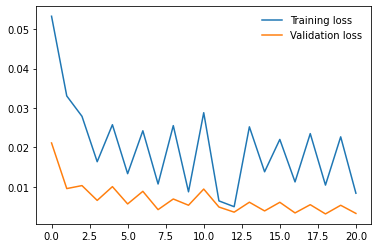

In [75]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()